In [5]:
import time

import cv2

from sequence_utils import VOTSequence
from ncc_tracker_example import NCCTracker, NCCParams
from ms_tracker import MeanShiftTracker, MSParams
import glob
from matplotlib import pyplot as plt

# set the path to directory where you have the sequences
dataset_path = '/home/aljaz/FAKS/nmrv/project02/vot14' 
sequence = 'bolt'  # choose the sequence you want to test

win_name = 'Tracking window'
reinitialize = True
show_gt = True
video_delay = 15
font = cv2.FONT_HERSHEY_PLAIN
videos = glob.glob(dataset_path + '/*')

videos.remove(dataset_path + '/list.txt')
# visualization and setup parameters

def run_tracking(name, params = (15, 16, 0.01, 1e-7)):
    
    # create sequence object
    if params == None: 
        params = (15, 16, 0.01, 1e-7)

    sequence = VOTSequence(dataset_path, name)
    init_frame = 0
    n_failures = 0

    # create parameters and tracker objects
    parameters = MSParams(*params)
    tracker = MeanShiftTracker(parameters)

    time_all = 0

    # initialize visualization window
    # sequence.initialize_window(win_name)
    # tracking loop - goes over all frames in the video sequence
    frame_idx = 0
    while frame_idx < sequence.length():
        img = cv2.imread(sequence.frame(frame_idx))
        # initialize or track
        if frame_idx == init_frame:
            # initialize tracker (at the beginning of the sequence or after tracking failure)
            t_ = time.time()
            tracker.initialize(img, sequence.get_annotation(frame_idx, type='rectangle'))
            time_all += time.time() - t_
            predicted_bbox = sequence.get_annotation(frame_idx, type='rectangle')
        else:
            # track on current frame - predict bounding box
            t_ = time.time()
            predicted_bbox = tracker.track(img)
            time_all += time.time() - t_

        # calculate overlap (needed to determine failure of a tracker)
        gt_bb = sequence.get_annotation(frame_idx, type='rectangle')
        o = sequence.overlap(predicted_bbox, gt_bb)

        # draw ground-truth and predicted bounding boxes, frame numbers and show image
        # if show_gt:
        #     sequence.draw_region(img, gt_bb, (0, 255, 0), 1)
        # sequence.draw_region(img, predicted_bbox, (0, 0, 255), 2)
        # sequence.draw_text(img, '%d/%d' % (frame_idx + 1, sequence.length()), (25, 25))
        # sequence.draw_text(img, 'Fails: %d' % n_failures, (25, 55))
        # sequence.show_image(img, video_delay)
        # time.sleep(0.05)

        if o > 0 or not reinitialize:
            # increase frame counter by 1
            frame_idx += 1
        else:
            # increase frame counter by 5 and set re-initialization to the next frame
            frame_idx += 5
            init_frame = frame_idx
            n_failures += 1
            # print('/home/aljaz/FAKS/nmrv/project02/failures/' + name + '_fail_' + str(n_failures) + '.jpg')
            # cv2.imwrite('/home/aljaz/FAKS/nmrv/project02/failures/' + name + '_fail_' + str(n_failures) + '.jpg', img)                

    print('Tracking speed: %.1f FPS' % (sequence.length() / time_all))
    print('Tracker failed %d times' % n_failures)
    cv2.destroyAllWindows()

    return n_failures, (sequence.length() / time_all)

## base values

In [ ]:
all_failures = {}
fps = {}

for vid in videos:
    sequence = vid.split('/')[-1]
    # print(sequence)
    n_failures, f = run_tracking(sequence, (15, 16, 0.01))
    all_failures[sequence] = n_failures
    fps[sequence] = f

print(all_failures)
print(fps)



In [ ]:
print('Total Failures', sum(all_failures.values()))
print('Mean FPS: ', sum(fps.values()) / len(fps))

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
ax[0].bar(all_failures.keys(), all_failures.values())
ax[0].set_title('Failures')
ax[0].set_xticklabels(all_failures.keys(), rotation=90)
ax[1].bar(fps.keys(), fps.values())
ax[1].set_title('FPS')
ax[1].set_xticklabels(fps.keys(), rotation=90)
plt.tight_layout()

# plt.savefig('/project02/report_template/figures/vot_performance.pdf')


## Failure cases

In [3]:
# bolt
sequences = [ 'bolt', 'fish1', 'skating', 'tunnel']
for sequence in sequences:
    n_failures, f = run_tracking(sequence, (15, 16, 0.01))

/home/aljaz/FAKS/nmrv/project02/failures/bolt_fail_1.jpg
/home/aljaz/FAKS/nmrv/project02/failures/bolt_fail_2.jpg
/home/aljaz/FAKS/nmrv/project02/failures/bolt_fail_3.jpg
/home/aljaz/FAKS/nmrv/project02/failures/bolt_fail_4.jpg
Tracking speed: 501.4 FPS
Tracker failed 4 times
/home/aljaz/FAKS/nmrv/project02/failures/fish1_fail_1.jpg
/home/aljaz/FAKS/nmrv/project02/failures/fish1_fail_2.jpg
/home/aljaz/FAKS/nmrv/project02/failures/fish1_fail_3.jpg
/home/aljaz/FAKS/nmrv/project02/failures/fish1_fail_4.jpg
/home/aljaz/FAKS/nmrv/project02/failures/fish1_fail_5.jpg
Tracking speed: 693.5 FPS
Tracker failed 5 times
/home/aljaz/FAKS/nmrv/project02/failures/skating_fail_1.jpg
/home/aljaz/FAKS/nmrv/project02/failures/skating_fail_2.jpg
/home/aljaz/FAKS/nmrv/project02/failures/skating_fail_3.jpg
/home/aljaz/FAKS/nmrv/project02/failures/skating_fail_4.jpg
/home/aljaz/FAKS/nmrv/project02/failures/skating_fail_5.jpg
Tracking speed: 346.0 FPS
Tracker failed 5 times
/home/aljaz/FAKS/nmrv/project02/fai

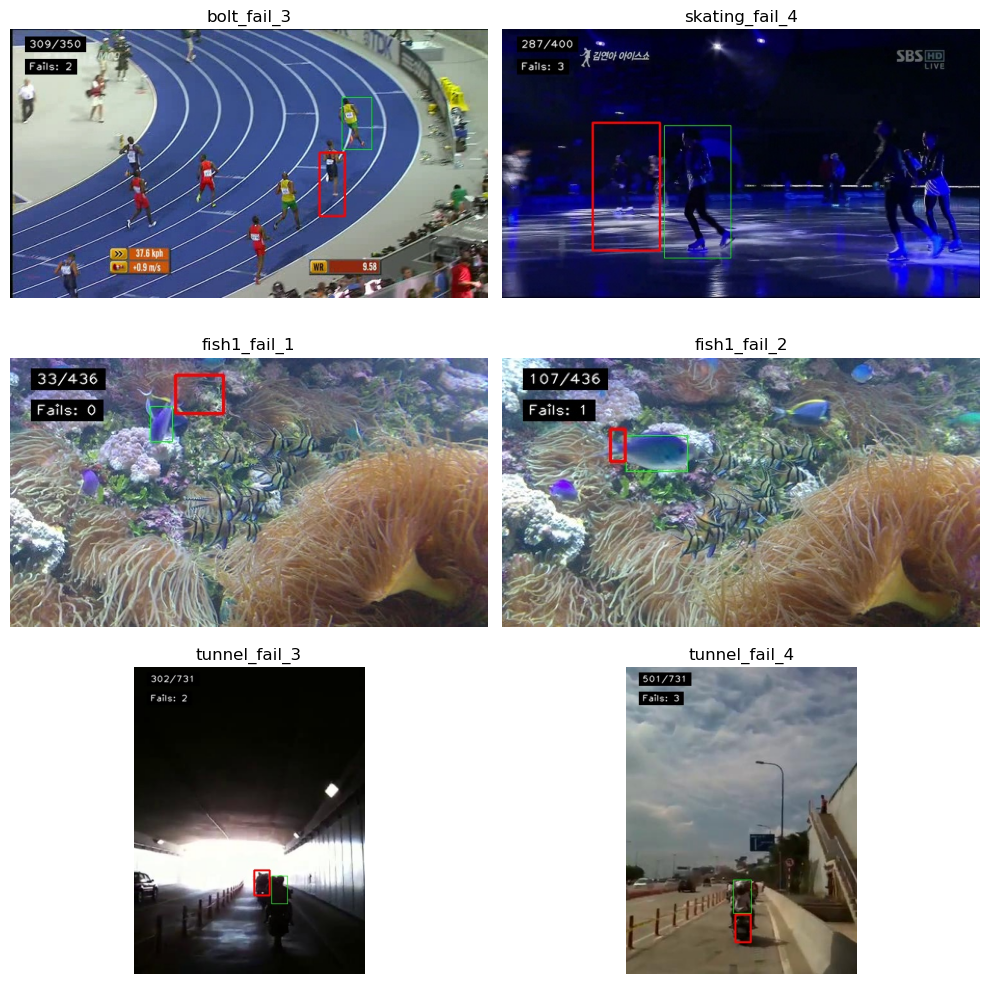

In [18]:
location = '/home/aljaz/FAKS/nmrv/project02/failures'
names = ['bolt_fail_3.jpg', 'skating_fail_4.jpg', 'fish1_fail_1.jpg', 'fish1_fail_2.jpg', 'tunnel_fail_3.jpg', 'tunnel_fail_4.jpg']

fig, ax = plt.subplots(3, 2, figsize=(10, 10))

for j in range(3):
    for i in range(2):
        ax[j, i].imshow(cv2.cvtColor(cv2.imread(location + '/' + names[2 * j + i]), cv2.COLOR_BGR2RGB))
        ax[j, i].axis('off')
        ax[j, i].set_title(names[2 * j + i].split('.')[0])

plt.tight_layout()
# plt.show()
plt.savefig('/home/aljaz/FAKS/nmrv/project02/report_template/figures/failures.pdf')


## Parameter search

In [7]:
kernel_sizes = [11,15, 21, 31, 51]
alphas = [0.01, 0.02, 0.05, 0.1]
eps = [ 1e-6 ,1e-8, 1e-9, 1e-10]
# kernel_sizes = [15]
# alphas = [0.01]
# eps = [1e-6]

import pandas as pd

combinations = [(k, 16, a, e) for k in kernel_sizes for a in alphas for e in eps]

results = {}

for comb in combinations:
    comb_str = str(comb[0]) + '-' + str(comb[2])+ '-' + str(comb[3])
    print(comb_str)
    all_failures = []
    fps = []
    for vid in videos:
        sequence = vid.split('/')[-1]
        # print(sequence)
        n_failures, f = run_tracking(sequence, comb)
        all_failures.append(n_failures)
        fps.append(f)
    results[comb_str] = (sum(all_failures), sum(fps) / len(fps))
    print('Total failures: %d' % sum(all_failures))
    print('Average FPS: %.1f' % (sum(fps) / len(fps)))
print(results)

results = pd.DataFrame(results).T
results.columns = ['failures', 'fps']
results.to_csv('/home/aljaz/FAKS/nmrv/project02/report_template/grid_search_results.csv')


11-0.01-1e-06
Tracking speed: 385.9 FPS
Tracker failed 5 times
Tracking speed: 1375.7 FPS
Tracker failed 1 times
Tracking speed: 706.4 FPS
Tracker failed 1 times
Tracking speed: 617.9 FPS
Tracker failed 2 times
Tracking speed: 816.9 FPS
Tracker failed 5 times
Tracking speed: 398.7 FPS
Tracker failed 0 times
Tracking speed: 801.9 FPS
Tracker failed 1 times
Tracking speed: 745.8 FPS
Tracker failed 0 times
Tracking speed: 966.1 FPS
Tracker failed 2 times
Tracking speed: 995.7 FPS
Tracker failed 4 times
Tracking speed: 484.2 FPS
Tracker failed 2 times
Tracking speed: 729.9 FPS
Tracker failed 1 times
Tracking speed: 753.1 FPS
Tracker failed 2 times
Tracking speed: 612.2 FPS
Tracker failed 0 times
Tracking speed: 624.2 FPS
Tracker failed 4 times
Tracking speed: 651.2 FPS
Tracker failed 0 times
Tracking speed: 1081.2 FPS
Tracker failed 0 times
Tracking speed: 321.9 FPS
Tracker failed 1 times
Tracking speed: 1418.6 FPS
Tracker failed 0 times
Tracking speed: 176.5 FPS
Tracker failed 3 times
Tra